<a href="https://colab.research.google.com/github/abstractguy/TSO_project/blob/master/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Convert a MobileNet's weights to a C array.

TODO: Implement MobileNetv1-SSDLite with various optimizations and keep it fitting in an ESP32.

In [1]:
input_shape = (128, 128, 3)
alpha = 0.25
x_size, y_size, channel_size = input_shape
model_filename = 'mobilenet_model_quantized'
model_tflite = model_filename + '.tflite'
model_cc = model_filename + '.cc'
origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

In [2]:
!sudo bash -c 'apt update -qq && apt install -yqq xxd'

21 packages can be upgraded. Run 'apt list --upgradable' to see them.
xxd is already the newest version (2:8.0.1453-1ubuntu1.4).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [3]:
import pathlib
import numpy as np
import tensorflow as tf
from google.colab import files

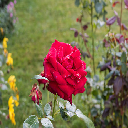

In [4]:
data_dir = pathlib.Path(tf.keras.utils.get_file(origin=origin, fname='flower_photos', untar=True))
flower_path = list(data_dir.glob('*roses*/*'))[0]
img = tf.keras.preprocessing.image.load_img(flower_path, target_size=input_shape)
img

In [5]:
mobilenet = tf.keras.applications.mobilenet
model = mobilenet.MobileNet(input_shape=input_shape, alpha=alpha)

In [6]:
def prepare_image(img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return mobilenet.preprocess_input(img_array_expanded_dims)

In [7]:
preprocessed_image = prepare_image(img)
predictions = model.predict(preprocessed_image)
tf.keras.applications.imagenet_utils.decode_predictions(predictions)

[[('n13037406', 'gyromitra', 0.3515073),
  ('n02279972', 'monarch', 0.11089101),
  ('n12620546', 'hip', 0.04783753),
  ('n02206856', 'bee', 0.039782953),
  ('n07768694', 'pomegranate', 0.036964178)]]

In [8]:
model.summary()

Model: "mobilenet_0.25_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 8)         216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 8)         32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 8)         0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 8)         72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 8)  

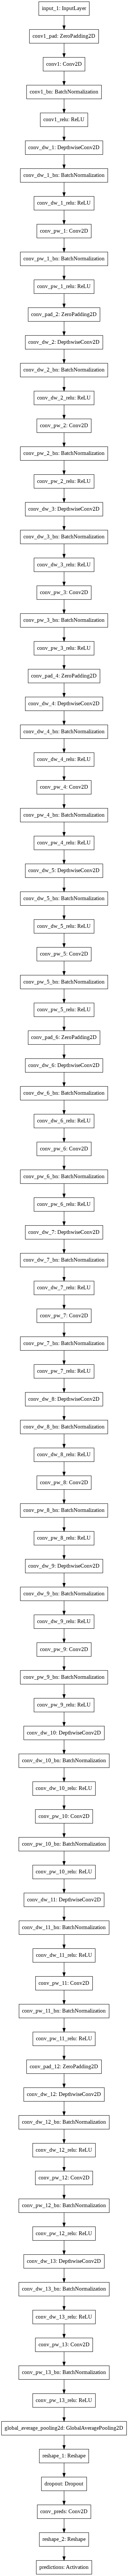

In [9]:
tf.keras.utils.plot_model(model, to_file='model.png')

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
open(model_tflite, 'wb').write(converter.convert())

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpve406r73/assets


510656

In [11]:
!xxd -i $model_tflite > $model_cc
!cat $model_cc

Streaming output truncated to the last 5000 lines.
  0xfe, 0xfb, 0x02, 0x05, 0x01, 0xff, 0x00, 0xfc, 0x04, 0x00, 0x02, 0x06,
  0x00, 0xfa, 0x06, 0xfb, 0xff, 0xfe, 0x02, 0x00, 0x07, 0xfa, 0x08, 0x06,
  0xfb, 0xfe, 0x00, 0x00, 0x01, 0xfd, 0x01, 0xff, 0xff, 0xfd, 0xff, 0x02,
  0x08, 0xf9, 0xff, 0x02, 0x06, 0xf7, 0x00, 0x03, 0xff, 0xfd, 0xf1, 0xff,
  0xfe, 0x02, 0xff, 0xfe, 0x06, 0xfe, 0xfe, 0xfb, 0xff, 0xfd, 0xfe, 0x05,
  0xfe, 0x06, 0xfd, 0xfc, 0x01, 0x03, 0x03, 0x02, 0x00, 0x01, 0xfe, 0x02,
  0x01, 0x01, 0x00, 0x05, 0x00, 0x00, 0x09, 0xfe, 0x00, 0x01, 0x03, 0x00,
  0x00, 0xff, 0x02, 0xff, 0x02, 0x03, 0xfe, 0xfa, 0x06, 0xfe, 0xfe, 0x00,
  0x02, 0x07, 0x01, 0x02, 0xff, 0x02, 0x02, 0x00, 0x02, 0x02, 0xfb, 0xfd,
  0x01, 0x04, 0xff, 0xff, 0xfc, 0x04, 0xfd, 0x02, 0x00, 0x02, 0xfd, 0x0a,
  0xff, 0xfb, 0x06, 0xfe, 0xff, 0xff, 0xfe, 0xff, 0xfe, 0xfa, 0x09, 0xfa,
  0x03, 0x01, 0xff, 0xfe, 0xff, 0x01, 0x00, 0xfd, 0x03, 0x01, 0x02, 0x01,
  0xfe, 0xff, 0x04, 0xff, 0xfd, 0x03, 0x00, 0xfd, 0xfd, 0xfd,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
files.download(model_tflite)
files.download(model_cc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>